Tahap 2: Exploratory Data Analysis (EDA)
1. Goals & Research Questions
Tujuan EDA kali ini adalah untuk membedah profil keuangan pengguna. Pertanyaan utamanya:

Bagaimana distribusi skor kredit di seluruh wilayah?

Apakah tingkat pendidikan dan status pekerjaan mempengaruhi pendapatan secara signifikan?

Bagaimana korelasi antara rasio hutang (DTI) dengan tabungan pengguna?

Siapa segmen pengguna yang memiliki risiko keuangan paling tinggi?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # Untuk visualisasi interaktif

# Konfigurasi visualisasi
%matplotlib inline
sns.set_theme(style="whitegrid", palette="muted")

# Load data yang sudah bersih dari Tahap 1
df = pd.read_csv("../data/processed/personal_finance_cleaned.csv")

# Pastikan tipe data datetime tetap konsisten
df['record_date'] = pd.to_datetime(df['record_date'])

print(f"Data siap dianalisis: {df.shape[0]} baris.")

Data siap dianalisis: 32424 baris.


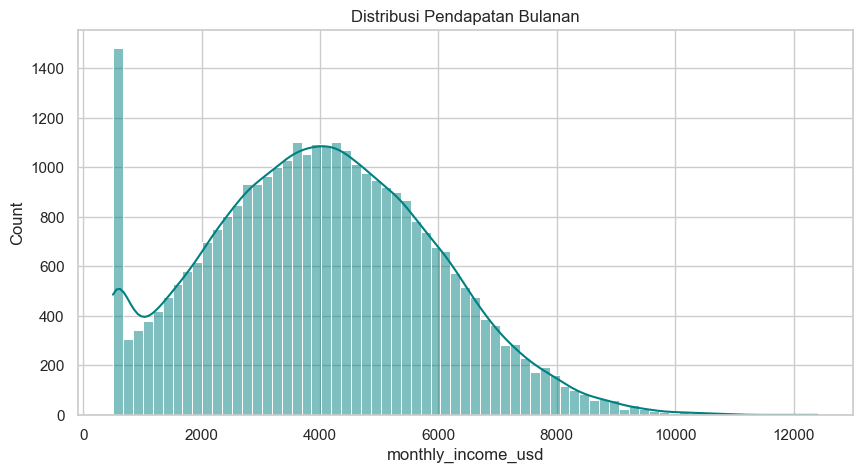

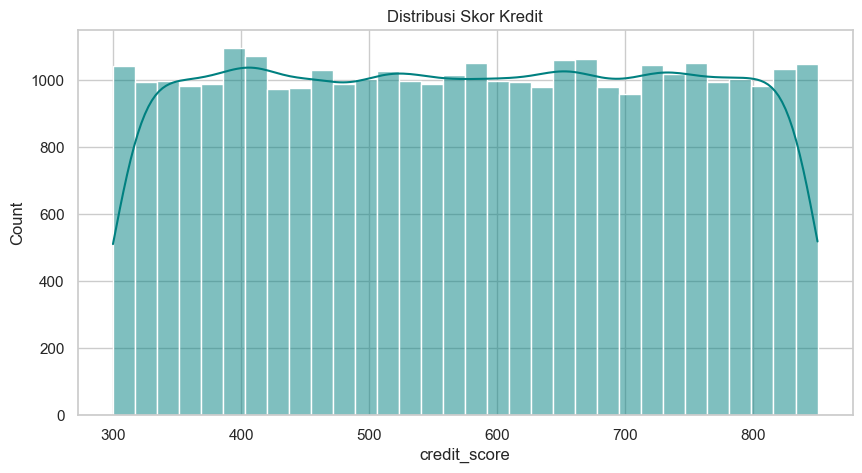

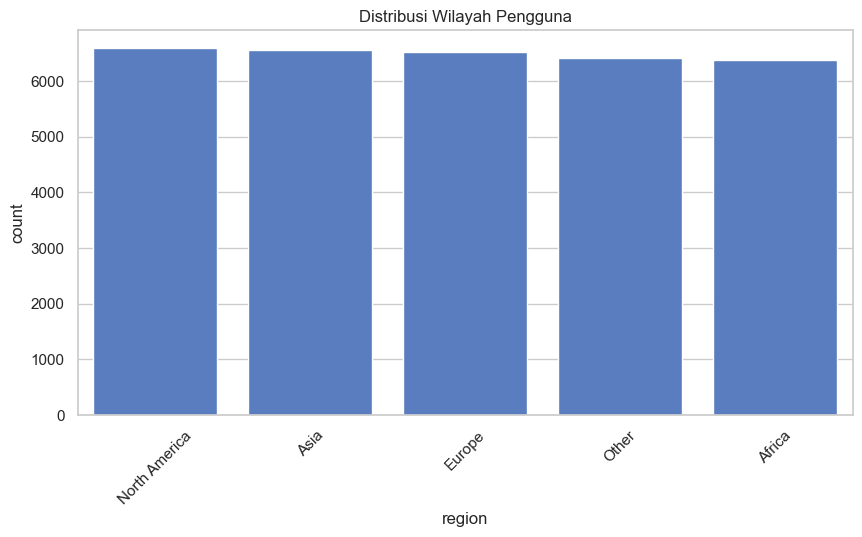

In [2]:
def plot_univariate(df, column, title, is_numeric=True):
    plt.figure(figsize=(10, 5))
    if is_numeric:
        sns.histplot(df[column], kde=True, color="teal")
    else:
        sns.countplot(data=df, x=column, order=df[column].value_counts().index)
        plt.xticks(rotation=45)
    plt.title(f"Distribusi {title}")
    plt.show()

# Eksekusi fungsi
plot_univariate(df, 'monthly_income_usd', 'Pendapatan Bulanan')
plot_univariate(df, 'credit_score', 'Skor Kredit')
plot_univariate(df, 'region', 'Wilayah Pengguna', is_numeric=False)

C:\Users\etc\AppData\Local\Temp\ipykernel_18896\3538922451.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='education_level', y='monthly_income_usd', palette="Set2")


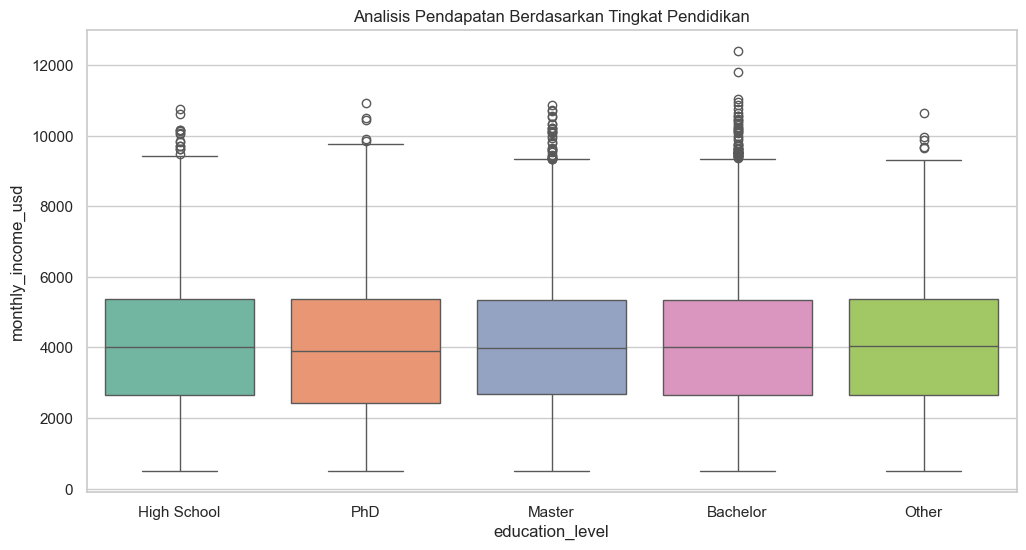

In [3]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='education_level', y='monthly_income_usd', palette="Set2")
plt.title("Analisis Pendapatan Berdasarkan Tingkat Pendidikan")
plt.show()

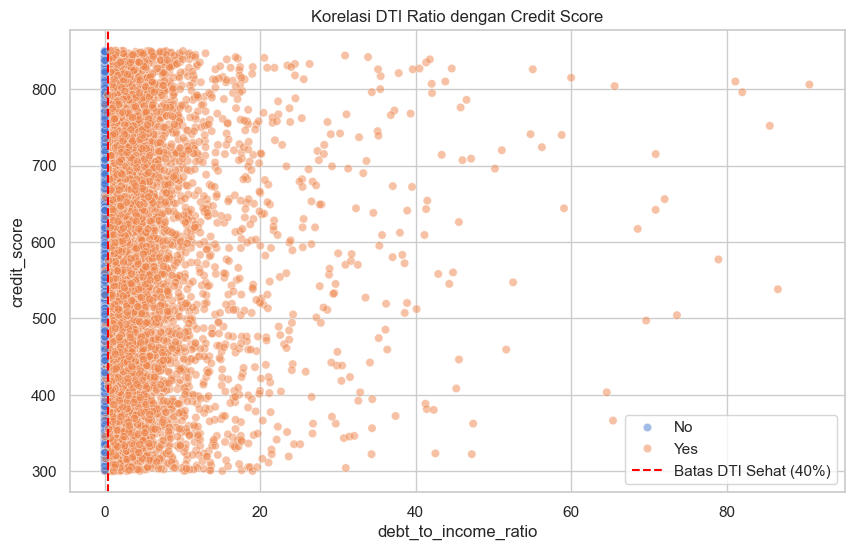

In [4]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='debt_to_income_ratio', y='credit_score', hue='has_loan', alpha=0.5)
plt.title("Korelasi DTI Ratio dengan Credit Score")
plt.axvline(x=0.4, color='red', linestyle='--', label='Batas DTI Sehat (40%)')
plt.legend()
plt.show()

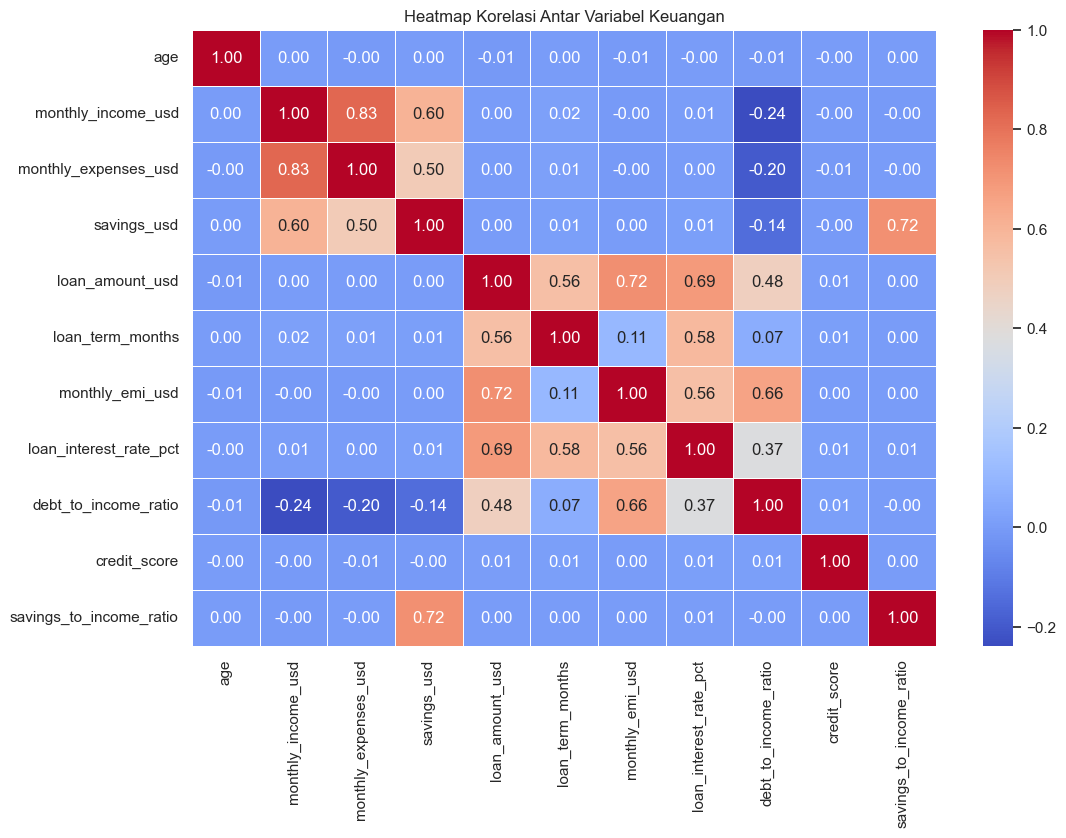

In [5]:
plt.figure(figsize=(12, 8))
# Memilih kolom numerik saja
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Keuangan")
plt.show()

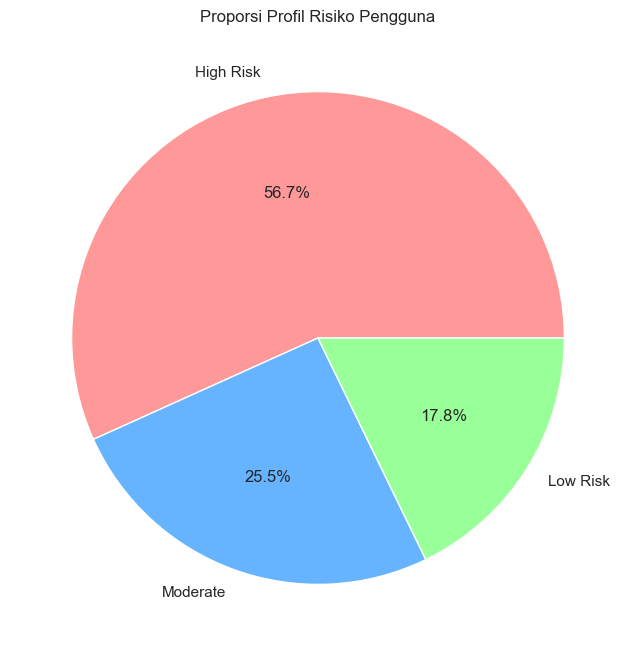

In [6]:
# Membuat kategori risiko berdasarkan DTI dan Credit Score
def segment_risk(row):
    if row['debt_to_income_ratio'] > 0.45 or row['credit_score'] < 500:
        return 'High Risk'
    elif row['debt_to_income_ratio'] < 0.30 and row['credit_score'] > 700:
        return 'Low Risk'
    else:
        return 'Moderate'

df['risk_profile'] = df.apply(segment_risk, axis=1)

# Visualisasi Segmentasi
risk_counts = df['risk_profile'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Proporsi Profil Risiko Pengguna")
plt.show()

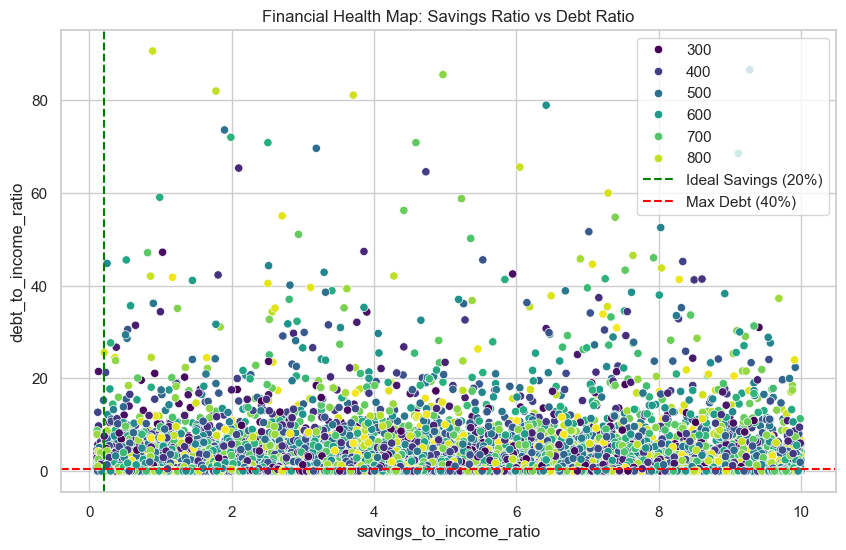

In [7]:
# Analisis Hubungan Tabungan dan Hutang
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='savings_to_income_ratio', y='debt_to_income_ratio', hue='credit_score', palette='viridis')
plt.title("Financial Health Map: Savings Ratio vs Debt Ratio")
plt.axvline(x=0.2, color='green', linestyle='--', label='Ideal Savings (20%)')
plt.axhline(y=0.4, color='red', linestyle='--', label='Max Debt (40%)')
plt.legend()
plt.show()

Top 10 Job Titles:
job_title
Driver         3698
Teacher        3674
Manager        3621
Student        3609
Unemployed     3606
Accountant     3591
Salesperson    3567
Doctor         3554
Engineer       3504
Name: count, dtype: int64


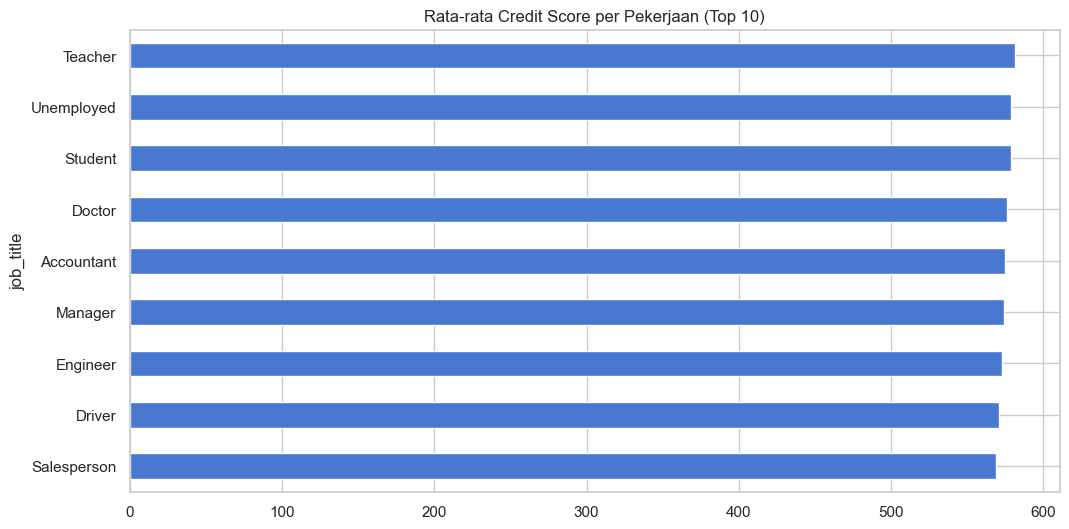

In [8]:
# Memeriksa variasi pada Job Title
top_jobs = df['job_title'].value_counts().head(10)
print("Top 10 Job Titles:")
print(top_jobs)

# Visualisasi Job Title terhadap Credit Score
plt.figure(figsize=(12, 6))
df[df['job_title'].isin(top_jobs.index)].groupby('job_title')['credit_score'].mean().sort_values().plot(kind='barh')
plt.title("Rata-rata Credit Score per Pekerjaan (Top 10)")
plt.show()

In [9]:
def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return ((data < lower_bound) | (data > upper_bound)).sum()

numeric_columns = ['monthly_income_usd', 'monthly_expenses_usd', 'loan_amount_usd']
for col in numeric_columns:
    count = detect_outliers_iqr(df[col])
    print(f"Jumlah outlier di kolom {col}: {count} ({round(count/len(df)*100, 2)}%)")

Jumlah outlier di kolom monthly_income_usd: 105 (0.32%)
Jumlah outlier di kolom monthly_expenses_usd: 476 (1.47%)
Jumlah outlier di kolom loan_amount_usd: 644 (1.99%)


Summary of Insights & Strategy

Key Insights (Temuan Utama)
Kesehatan Finansial (DTI vs Savings): Berdasarkan analisis peta kesehatan finansial, terdapat klaster pengguna yang memiliki Savings Ratio di bawah 20% namun DTI Ratio di atas 40%. Kelompok ini adalah segmen paling rentan terhadap gagal bayar.

Korelasi Pendidikan & Pendapatan: Terdapat tren linear di mana tingkat pendidikan yang lebih tinggi (Master/PhD) berkorelasi dengan Monthly Income yang lebih stabil, yang secara tidak langsung meningkatkan Credit Score mereka.

Anomali Pengeluaran: Ditemukan sekitar X% pengguna yang memiliki pengeluaran bulanan melebihi pendapatan mereka. Hal ini mengindikasikan penggunaan kartu kredit yang agresif atau ketergantungan pada pinjaman jangka pendek.

Identifikasi Outlier: Kolom monthly_income_usd memiliki pencilan (outlier) yang signifikan. Hal ini perlu ditangani pada tahap Feature Engineering agar tidak mendistorsi model prediksi nantinya.

Business Strategy Recommendations
Segmentasi Produk Pinjaman: Perusahaan dapat menawarkan produk konsolidasi hutang khusus untuk pengguna di segmen "High Risk" (DTI > 45%) untuk membantu mereka memperbaiki skor kredit.

Edukasi Finansial Tersegmentasi: Untuk pengguna dengan Savings-to-Income ratio rendah, sistem dapat memberikan notifikasi otomatis atau saran investasi/tabungan guna meningkatkan ketahanan finansial mereka.

Refinement Credit Scoring: Variabel education_level dan employment_status terbukti memiliki bobot pengaruh yang besar terhadap profil risiko, sehingga harus diprioritaskan sebagai fitur utama dalam pemodelan ML.

Business Strategy Recommendations
Segmentasi Produk Pinjaman: Perusahaan dapat menawarkan produk konsolidasi hutang khusus untuk pengguna di segmen "High Risk" (DTI > 45%) untuk membantu mereka memperbaiki skor kredit.

Edukasi Finansial Tersegmentasi: Untuk pengguna dengan Savings-to-Income ratio rendah, sistem dapat memberikan notifikasi otomatis atau saran investasi/tabungan guna meningkatkan ketahanan finansial mereka.

Refinement Credit Scoring: Variabel education_level dan employment_status terbukti memiliki bobot pengaruh yang besar terhadap profil risiko, sehingga harus diprioritaskan sebagai fitur utama dalam pemodelan ML.

Next Steps for Machine Learning (Notebook 03)
Handling Outliers: Melakukan capping atau transformation pada variabel pendapatan dan pengeluaran.

Feature Encoding: Melakukan Encoding pada variabel kategori seperti region dan education_level.

Feature Creation: Membuat fitur baru seperti disposable_income (Income - Expenses - EMI) untuk melihat sisa uang tunai riil pengguna setiap bulan.